## Constants

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

# -----------------------------
# Link lengths
# -----------------------------
l_1 = 0.29 #m
l_2 = 0.46 #m
l_3 = 0.044 #m
l_4 = 0.43 #m
l_5 = 0.075 #m  

# -----------------------------
# Theta1 range (input crank)
# -----------------------------
theta1 = np.linspace(0.174533, 0.20944, 400)

# -----------------------------
# Fixed points
# -----------------------------
O = np.array([0.0, 0.0])
C = np.array([0.0, l_4])
E = np.array([C[0] - 0.2, C[1]])

# -----------------------------
# Spring 
# -----------------------------
L0 = 0.178   # spring rest length m
ks  = 79000   # spring constant N/m

### Computing angles and coordinates of points

In [11]:
# -----------------------------
# Storage for variables
# -----------------------------
A = np.zeros((len(theta1), 2))
B = np.zeros((len(theta1), 2))
D = np.zeros((len(theta1), 2))

# -----------------------------
# Geometry solver
# -----------------------------
for i, t1 in enumerate(theta1):

    A[i] = O + np.array([l_1*np.cos(t1), l_1*np.sin(t1)]) # Point A position

    d = np.linalg.norm(C - A[i]) # Distance AC

    if d > l_2 + l_3 or d < abs(l_2 - l_3): # Checking for triangle inequality, otherwise skip this frame
        B[i] = np.nan
        D[i] = np.nan
        continue

    a = (l_2**2 - l_3**2 + d**2) / (2*d) # Length from A to P along AC, using law of cosines
    h = np.sqrt(l_2**2 - a**2) # Height from P to B, perpendicular to AC
    P = A[i] + a*(C - A[i]) / d # Point P position

    B[i,0] = P[0] + h*(C[1] - A[i,1]) / d # Point Bx position
    B[i,1] = P[1] - h*(C[0] - A[i,0]) / d # Point By position
    #Solving for point D
    v3 = C - B[i] # Vector from B to C
    v3_hat = v3 / np.linalg.norm(v3) # Unit vector along link 3
    n_hat = np.array([v3_hat[1], -v3_hat[0]]) # Perpendicular unit vector to link 3
    D[i] = C + l_5 * n_hat # Vector C to D is always perpendicular to link 3
# -----------------------------
# Remove invalid frames
# -----------------------------
valid = ~np.isnan(B[:,0])
theta1 = theta1[valid]
A = A[valid]
B = B[valid]
D = D[valid]

# -----------------------------
# Spring force magnitude & tension/compression
# -----------------------------
spring_len = np.linalg.norm(D - E, axis=1) - 0.01905  # instantaneous spring length at each frame
spring_extension = L0 - spring_len  # spring compression/extension
Fs = ks * spring_extension # spring force magnitude

# -----------------------------
# Storage for variables
# -----------------------------
th1_arr = np.zeros(len(A))
th2_arr = np.zeros(len(A))
th3_arr = np.zeros(len(A))
th4_arr = np.zeros(len(A))
th5_arr = np.zeros(len(A))
# -----------------------------
# Compute angles
# -----------------------------
def angle_deg(p1, p2): # angle from p1 to p2 in degrees
    v = p2 - p1
    return np.degrees(np.arctan2(v[1], v[0]))

def small_angle_deg(th): # wrap angle to [-90, 90] degrees (only used for th4 bc its cw positive)
    th = (th + 180) % 360 - 180
    if th > 90:
        th -= 180
    elif th < -90:
        th += 180
    return th

for i in range(len(A)):
    th1_arr[i] = angle_deg(O, A[i])
    th2_arr[i] = angle_deg(A[i], B[i])
    th3_arr[i] = angle_deg(C, B[i])
    th4_arr[i] = angle_deg(C, D[i])
    th5_arr[i] = angle_deg(E, D[i])


### Computing forces in links

In [12]:
# -----------------------------
# Solution arrays:
n = len(th1_arr)

Ax_arr = np.zeros(n)
Ay_arr = np.zeros(n)
Bx_arr = np.zeros(n)
By_arr = np.zeros(n)
Cx_arr = np.zeros(n)
Cy_arr = np.zeros(n)
Ox_arr = np.zeros(n)
Oy_arr = np.zeros(n)
N_arr  = np.zeros(n)
# ----------------------------- 
# Setting up system of equations

def build_linear_system(th1, th2, th3, th4, th5, Fs):

    M = np.zeros((9, 9))
    b = np.zeros(9)

    # -------------------------------------------------
    # Equation 1
    # -------------------------------------------------
    M[0, :] = [0, 0, -1, 0, 1, 0, 0, 0, 0]
    b[0]    = -Fs*np.cos(np.radians(th5))

    # -------------------------------------------------
    # Equation 2
    # -------------------------------------------------
    M[1, :] = [0, 0, 0, -1, 0, 1, 0, 0, 0]
    b[1]    = -Fs*np.sin(np.radians(th5))

    # -------------------------------------------------
    # Equation 3
    # -------------------------------------------------
    M[2, :] = [0, 0, l_3*np.sin(np.radians(th3)), -l_3*np.cos(np.radians(th3)), 0, 0, 0, 0, 0]
    b[2]    = -l_5*Fs*np.sin(np.radians(th5-th4))

    # -------------------------------------------------
    # Equation 4
    # -------------------------------------------------
    M[3, :] = [-1, 0, 1, 0, 0, 0, 0, 0, 0]
    b[3]    = 0

    # -------------------------------------------------
    # Equation 5
    # -------------------------------------------------
    M[4, :] = [0, -1, 0, 1, 0, 0, 0, 0, 1]
    b[4]    = 0

    # -------------------------------------------------
    # Equation 6
    # -------------------------------------------------
    M[5, :] = [0, 0, -l_2*np.sin(np.radians(th2)), l_2*np.cos(np.radians(th2)), 0, 0, 0, 0, 0]
    b[5]    = 0

    # -------------------------------------------------
    # Equation 7
    # -------------------------------------------------
    M[6, :] = [1, 0, 0, 0, 0, 0, 1, 0, 0]
    b[6]    = 0

    # -------------------------------------------------
    # Equation 8
    # -------------------------------------------------
    M[7, :] = [0, 1, 0, 0, 0, 0, 0, 1, 0]
    b[7]    = 0

    # -------------------------------------------------
    # Equation 9
    # -------------------------------------------------
    M[8, :] = [-l_1*np.sin(np.radians(th1)), l_1*np.cos(np.radians(th1)), 0, 0, 0, 0, 0, 0, 0]
    b[8]    = 0

    return M, b

for i in range(n):

    M, b = build_linear_system(
        th1_arr[i],
        th2_arr[i],
        th3_arr[i],
        th4_arr[i],
        th5_arr[i],
        Fs[i] 
    )

    X = np.linalg.solve(M, b)

    Ax_arr[i], Ay_arr[i], \
    Bx_arr[i], By_arr[i], \
    Cx_arr[i], Cy_arr[i], \
    Ox_arr[i], Oy_arr[i], \
    N_arr[i] = X

## Finding effective spring constant

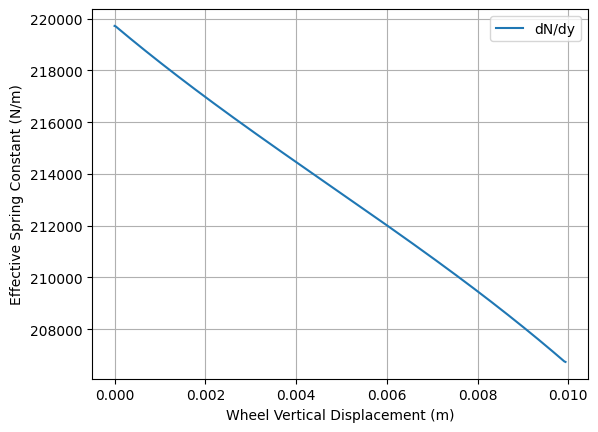

In [13]:
# -----------------------------
# y coordinate (vertical position of point A)
# -----------------------------
y = A[:, 1]
y = y - y[0]

# -----------------------------
# Direct stiffness: dN/dy
# -----------------------------
k_eff = np.gradient(N_arr, y)
k_interp = interp1d(y, k_eff, fill_value="extrapolate")

# -----------------------------
# Overlay comparison
# -----------------------------
plt.figure()
plt.plot(y, k_eff, label="dN/dy")
plt.xlabel("Wheel Vertical Displacement (m)")
plt.ylabel("Effective Spring Constant (N/m)")
plt.grid(True)
plt.legend()
plt.show()


## Spring Mass System

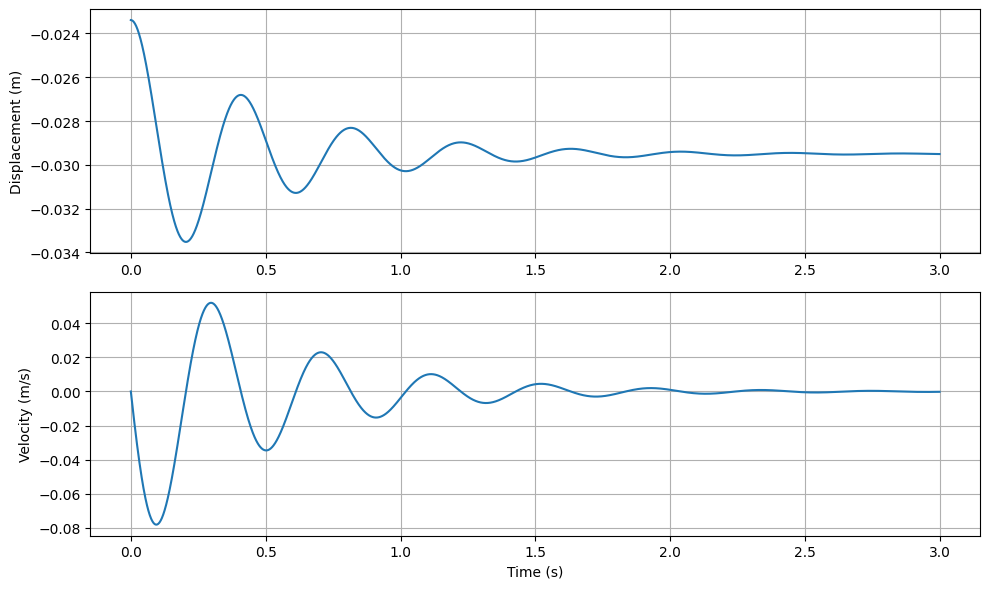

0
The solver successfully reached the end of the integration interval.
Final time reached: 2.999
Last state: [-0.02950766 -0.00018696]


In [14]:
# ---- Simulation parameters ----
m = 1000 #66.904875    # sprung mass [kg]
c = 4000       # damping [N·s/m] (lower for visible oscillation)
x_init = -0.023394191990219634   # Positive is downward from equilibrium
x_eq = -0.0295  # equilibrium position
v_init = 0.0    # small initial velocity optional
t_final = 3    # seconds
dt = 0.001

# ---- Nonlinear spring-mass-damper ODE ----
def spring_mass(t, state, m, c):
    x, v = state
    k_local = k_interp(x)        # wheel-rate at current displacement
    F_ext = 0.0                  # no external force
    F_spring = k_local * (x - x_eq) # spring force relative to equilibrium position
    a = (F_ext - c*v - F_spring) / m
    return [v, a]

# ---- Solve ODE ----
t_eval = np.arange(0, t_final, dt)
ic = [x_init, v_init]
sol = solve_ivp(spring_mass, [0, t_final], ic, args=(m, c), t_eval=t_eval, rtol=1e-6, atol=1e-8)

# ---- Plot displacement and velocity ----
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.plot(sol.t, sol.y[0])
plt.ylabel('Displacement (m)')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(sol.t, sol.y[1])
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.tight_layout()
plt.show()

print(sol.status)
print(sol.message)
print("Final time reached:", sol.t[-1])
print("Last state:", sol.y[:, -1])


## Comparing to Tracker Data 

C:\Users\zsong\AppData\Local\Temp\ipykernel_34840\653869606.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


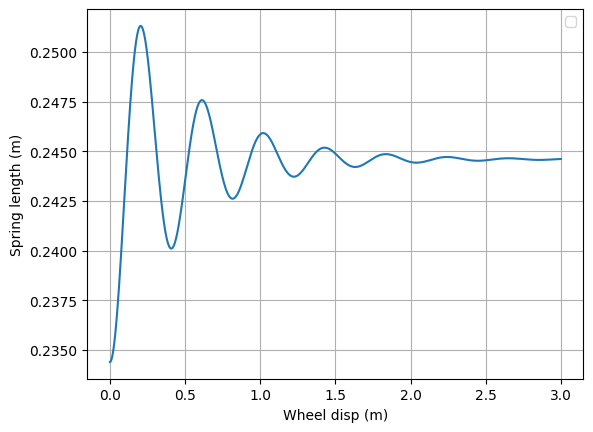

In [15]:
#Relating spring length to body vertical displacement and vice versa (check?)
L_shift = 0
dA_y = A[:, 1] - A[:, 1][0]
spring_length = np.linalg.norm(D - E, axis=1) + L_shift

length_to_disp = interp1d(spring_length, dA_y, fill_value="extrapolate")
disp_to_length = interp1d(dA_y, spring_length, fill_value="extrapolate")

plt.figure()
plt.plot(sol.t, disp_to_length(sol.y[0]))
plt.xlabel("Wheel disp (m)")
plt.ylabel("Spring length (m)")
plt.grid(True)
plt.legend()
plt.show()

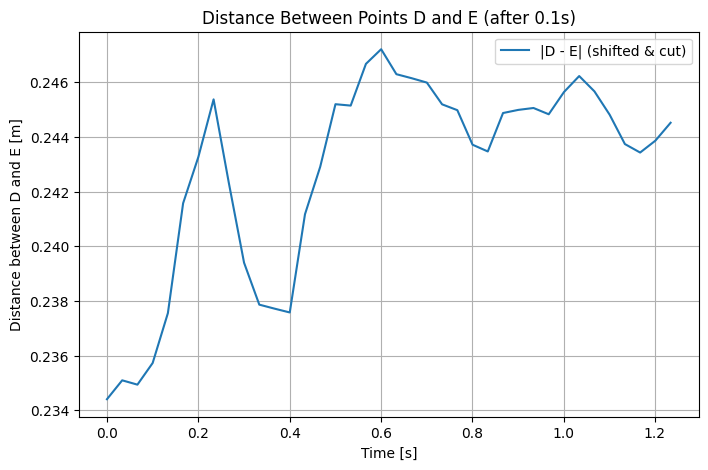

In [16]:
# -----------------------------
# Load tracker data
# -----------------------------
tracker_data_E = np.genfromtxt("Point E.txt", delimiter=",", skip_header=2)
tracker_data_D = np.genfromtxt("Point D.txt", delimiter=",", skip_header=2)

# Time vectors
t_E = tracker_data_E[:, 0]
t_D = tracker_data_D[:, 0]

# Point positions as (x, y)
E_tracker = tracker_data_E[:, 1:3]
D_tracker = tracker_data_D[:, 1:3]

# -----------------------------
# Interpolate D onto E's time base
# -----------------------------
Dx_interp = np.interp(t_E, t_D, D_tracker[:, 0])
Dy_interp = np.interp(t_E, t_D, D_tracker[:, 1])
D_interp = np.column_stack((Dx_interp, Dy_interp))

# -----------------------------
# Shift time to start at 0
# -----------------------------
t_shifted = t_E - t_E[0]

# -----------------------------
# Cut the first 0.1 seconds
# -----------------------------
start_idx = np.searchsorted(t_shifted, 0.1)
t_cut = t_shifted[start_idx:]
E_cut = E_tracker[start_idx:]
D_cut = D_interp[start_idx:]

# -----------------------------
# Shift cut time back to start at 0
# -----------------------------
t_cut = t_cut - t_cut[0]

# -----------------------------
# Compute distance after cut
# -----------------------------
distance_ED_cut = np.linalg.norm(D_cut - E_cut, axis=1)

# -----------------------------
# Plot processed distance
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(t_cut, distance_ED_cut, label="|D - E| (shifted & cut)")
plt.xlabel("Time [s]")
plt.ylabel("Distance between D and E [m]")
plt.title("Distance Between Points D and E (after 0.1s)")
plt.grid(True)
plt.legend()
plt.show()


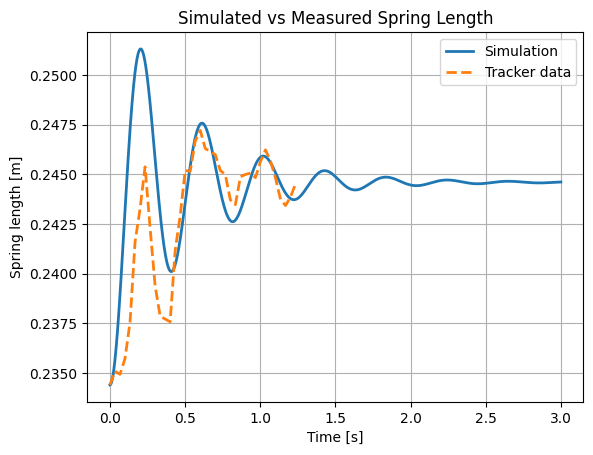

In [17]:
plt.figure()
# Simulation: spring length from displacement of sol
plt.plot(sol.t, disp_to_length(sol.y[0]), label="Simulation", linewidth=2)
# Tracker data: measured spring length
plt.plot(t_cut, distance_ED_cut, label="Tracker data", linestyle='--', linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Spring length [m]")
plt.title("Simulated vs Measured Spring Length")
plt.grid(True)
plt.legend()
plt.show()

## Force Plots

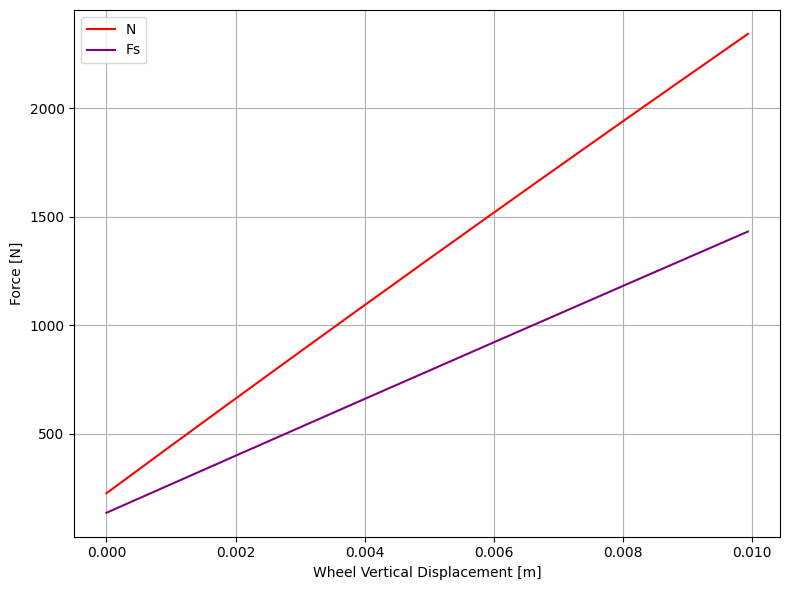

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot N
ax.plot(dA_y, N_arr, label='N', color='red')

# Plot Fs
ax.plot(dA_y, Fs, label='Fs', color='purple')

ax.set_xlabel('Wheel Vertical Displacement [m]')
ax.set_ylabel('Force [N]')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()